In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    print("Agrego el src")

/home/apernin/.dev/tda_2023Q1/tp2/src
Agrego el src


In [2]:
from data import generate_random_data
from algorithms import pack, smartpack
from utils import perform_time_test

import matplotlib.pyplot as plt
import pandas as pd
import random
from collections.abc import Iterable
from multiprocessing import Pool

In [3]:
generate_random_data()

[0.77, 0.88, 0.26, 0.38, 0.79, 0.99, 0.35, 0.04, 0.68, 0.29]

In [4]:
def ratio_f(n, data):
    result_B, _ = perform_time_test(smartpack, data)
    result_A, _ = perform_time_test(pack, data)
    
    ratio = len(result_B)/len(result_A)
    if ratio > 1:
        pass
        #print(f"Encontre un dataset malo {ratio}, {data}")
    
    return n, len(result_A), len(result_B), ratio


def test_ratio(nsets: Iterable[float], pool_size=1):
    ns = []
    approximate_results = []
    new_results = []
    ratio_results = []

    async_responses = []
    
    with Pool(pool_size) as p:
        for data in nsets:
            nlen = len(data)
            #print(f'Llamo con {nlen} y {data}')
            async_res = p.apply_async(ratio_f, args=(nlen, data))
            #print(f'Obtuve como resultado de {nlen} en {exe_time}')
            async_responses.append(async_res)
            #time_results.append(exe_time)
            #ns.append(nlen)

        for async_res in async_responses:
            try:
                async_res.wait()
                n, result_approx, result_new, ratio = async_res.get()
                ns.append(n)
                approximate_results.append(result_approx)
                new_results.append(result_new)
                ratio_results.append(ratio)
            except KeyboardInterrupt:
                print("Exiting at client will")
                pass

    df = pd.DataFrame({'n': ns, 'approx': approximate_results, 'new_approx': new_results, 'ratio': ratio_results})
    return df

In [5]:
df_accum = None

In [23]:
%%time
min_n = 6
max_n = 1000
total_tests = 100000

testdata = (generate_random_data(length=random.randint(min_n, max_n)) for i in range(total_tests))
#list(testdata)
    
df_test = test_ratio(nsets=testdata, pool_size=4)
if df_accum is None:
    df_accum = df_test
else:
    df_accum = pd.concat([df_accum, df_test])
#df_test

CPU times: user 33.4 s, sys: 4.32 s, total: 37.7 s
Wall time: 54.6 s


In [24]:
len(df_accum)

400000

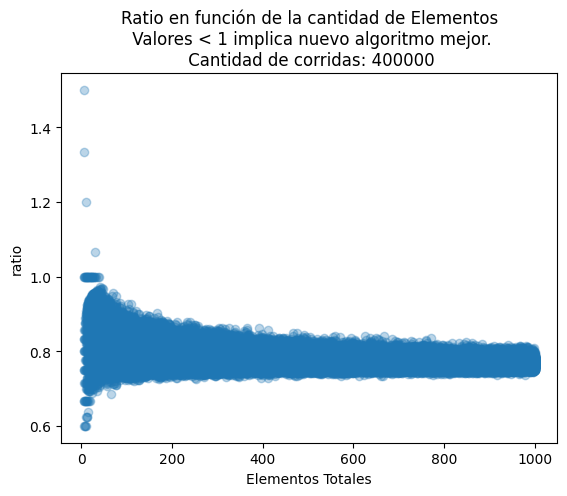

In [25]:
df_graf = df_accum.drop_duplicates(subset=['n', 'ratio'])
plt.scatter(df_graf['n'], df_graf['ratio'], alpha=0.3)
#plt.ylim(0, 3)
plt.xlabel("Elementos Totales")
plt.ylabel("ratio")
plt.title(f"Ratio en función de la cantidad de Elementos\n Valores < 1 implica nuevo algoritmo mejor.\n Cantidad de corridas: {len(df_accum)}")
plt.show()

In [26]:
total_elements = len(df_accum)
grouping = {
    'r<0.5': (df_accum['ratio'] < 0.5).sum(),
    '0.5<= r < 1': ((df_accum['ratio'] >= 0.5) & (df_accum['ratio'] < 1)).sum(),
    'r==1': (df_accum['ratio'] == 1).sum(),
    '1< r <= 1.5': ((df_accum['ratio'] > 1) & (df_accum['ratio']<= 1.5)).sum(),
    '1.5 < r <= 2': ((df_accum['ratio'] > 1.5) & (df_accum['ratio'] <=2 )).sum()
}
grouping

{'r<0.5': 0,
 '0.5<= r < 1': 398526,
 'r==1': 1469,
 '1< r <= 1.5': 5,
 '1.5 < r <= 2': 0}

In [27]:
ratio_g_keys = []
ratio_g_counts = []
ratio_g_percs = []

for key, counts in grouping.items():
    ratio_g_keys.append(key)
    ratio_g_counts.append(counts)
    ratio_g_percs.append(counts/total_elements)

df_ratios = pd.DataFrame({'group': ratio_g_keys, 'count': ratio_g_counts, 'perc': ratio_g_percs})
df_ratios

,group,count,perc
0,r<0.5,0,0.000000
1,0.5<= r < 1,398526,0.996315
2,r==1,1469,0.003672
3,1< r <= 1.5,5,0.000013
4,1.5 < r <= 2,0,0.000000


In [28]:
print(df_ratios.to_latex(index=False, column_format='|c|c|c|'))

\begin{tabular}{|c|c|c|}
\toprule
group & count & perc \\
\midrule
r<0.5 & 0 & 0.000000 \\
0.5<= r < 1 & 398526 & 0.996315 \\
r==1 & 1469 & 0.003672 \\
1< r <= 1.5 & 5 & 0.000013 \\
1.5 < r <= 2 & 0 & 0.000000 \\
\bottomrule
\end{tabular}



In [29]:
ranges_df = df_accum.groupby(pd.cut(df_accum['n'], [0, 200, 400, 600, 800, 1000])).count()
print(ranges_df.to_latex(index=True, columns=['n'], column_format='|c|c|'))
ranges_df

\begin{tabular}{|c|c|}
\toprule
 & n \\
n &  \\
\midrule
(0, 200] & 78217 \\
(200, 400] & 80354 \\
(400, 600] & 80124 \\
(600, 800] & 80553 \\
(800, 1000] & 80752 \\
\bottomrule
\end{tabular}



,n,approx,new_approx,ratio
n,,,,
"(0, 200]",78217,78217,78217,78217
"(200, 400]",80354,80354,80354,80354
"(400, 600]",80124,80124,80124,80124
"(600, 800]",80553,80553,80553,80553
"(800, 1000]",80752,80752,80752,80752


## Test of lower ranges

In [13]:
df_lower = None

In [22]:
%%time

testdata = (generate_random_data(length=random.randint(3, 10)) for i in range(1000000))
#list(testdata)
    
df_test = test_ratio(nsets=testdata, pool_size=4)
if df_lower is None:
    df_lower = df_test
else:
    df_lower = pd.concat([df_lower, df_test])

CPU times: user 33.1 s, sys: 10.9 s, total: 43.9 s
Wall time: 35.8 s


In [15]:
len(df_lower)

1000000

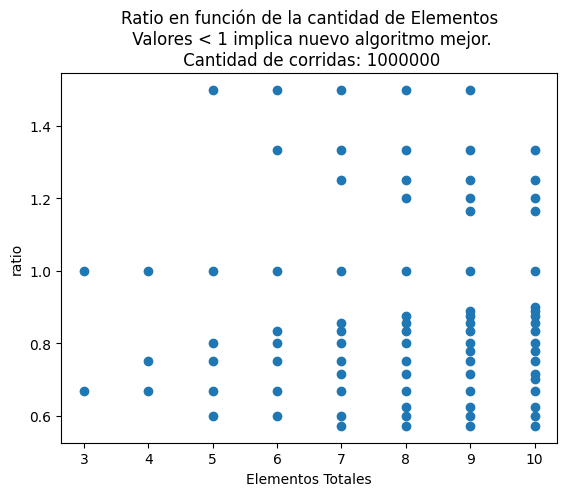

In [16]:
df_graf_lower = df_lower.drop_duplicates(subset=['n','ratio'])
plt.scatter(df_graf_lower['n'], df_graf_lower['ratio'], alpha=1)
#plt.ylim(0, 1)
plt.xlabel("Elementos Totales")
plt.ylabel("ratio")
plt.title(f"Ratio en función de la cantidad de Elementos\n Valores < 1 implica nuevo algoritmo mejor.\n Cantidad de corridas: {len(df_lower)}")
plt.show()

In [17]:
total_lower_elements = len(df_lower)
grouping_lower = {
    'r<0.5': (df_lower['ratio'] < 0.5).sum(),
    '0.5<= r < 1': ((df_lower['ratio'] >= 0.5) & (df_lower['ratio'] < 1)).sum(),
    'r==1': (df_lower['ratio'] == 1).sum(),
    '1< r <= 1.5': ((df_lower['ratio'] > 1) & (df_lower['ratio']<= 1.5)).sum(),
    '1.5 < r <= 2': ((df_lower['ratio'] > 1.5) & (df_lower['ratio'] <=2 )).sum()
}
grouping_lower

{'r<0.5': 0,
 '0.5<= r < 1': 394828,
 'r==1': 603489,
 '1< r <= 1.5': 1683,
 '1.5 < r <= 2': 0}

In [18]:
lower_ratio_g_keys = []
lower_ratio_g_counts = []
lower_ratio_g_percs = []

for key, counts in grouping_lower.items():
    lower_ratio_g_keys.append(key)
    lower_ratio_g_counts.append(counts)
    lower_ratio_g_percs.append(counts/total_lower_elements)

df_ratios_lower = pd.DataFrame({'group': lower_ratio_g_keys, 'count': lower_ratio_g_counts, 'perc': lower_ratio_g_percs})
print(df_ratios_lower.to_latex(index=False, column_format='|c|c|c|'))
df_ratios_lower

\begin{tabular}{|c|c|c|}
\toprule
group & count & perc \\
\midrule
r<0.5 & 0 & 0.000000 \\
0.5<= r < 1 & 394828 & 0.394828 \\
r==1 & 603489 & 0.603489 \\
1< r <= 1.5 & 1683 & 0.001683 \\
1.5 < r <= 2 & 0 & 0.000000 \\
\bottomrule
\end{tabular}



,group,count,perc
0,r<0.5,0,0.000000
1,0.5<= r < 1,394828,0.394828
2,r==1,603489,0.603489
3,1< r <= 1.5,1683,0.001683
4,1.5 < r <= 2,0,0.000000


## Test Smartpack vs Bruteforce

In [19]:
from algorithms import bruteforce

In [31]:
def ratio_f_opt(n, data):
    result_B, _ = perform_time_test(smartpack, data)
    result_A, _ = perform_time_test(bruteforce, data)
    
    ratio = len(result_B)/len(result_A)
    if ratio > 1:
        pass
        #print(f"Encontre un dataset malo {ratio}, {data}")
    
    return n, len(result_A), len(result_B), ratio


def test_ratio_opt(nsets: Iterable[float], pool_size=1):
    ns = []
    smartpack_results = []
    exact_results = []
    ratio_results = []

    async_responses = []
    
    with Pool(pool_size) as p:
        for data in nsets:
            nlen = len(data)
            #print(f'Llamo con {nlen} y {data}')
            async_res = p.apply_async(ratio_f_opt, args=(nlen, data))
            #print(f'Obtuve como resultado de {nlen} en {exe_time}')
            async_responses.append(async_res)
            #time_results.append(exe_time)
            #ns.append(nlen)

        for async_res in async_responses:
            try:
                async_res.wait()
                n, result_smartpack, result_exact, ratio = async_res.get()
                ns.append(n)
                smartpack_results.append(result_smartpack)
                exact_results.append(result_exact)
                ratio_results.append(ratio)
            except KeyboardInterrupt:
                print("Exiting at client will")
                pass

    df = pd.DataFrame({'n': ns, 'exact': exact_results, 'smartpack': smartpack_results, 'ratio': ratio_results})
    return df

In [41]:
df_smartpack_z = None

In [46]:
%%time
min_n = 3
max_n = 10
total_tests = 1000

testdata = (generate_random_data(length=random.randint(min_n, max_n)) for i in range(total_tests))
#list(testdata)
    
df_test = test_ratio_opt(nsets=testdata, pool_size=4)
if df_smartpack_z is None:
    df_smartpack_z = df_test
else:
    df_smartpack_z = pd.concat([df_smartpack_z, df_test])
#df_test

CPU times: user 276 ms, sys: 162 ms, total: 438 ms
Wall time: 13min 17s


In [47]:
len(df_test)

1000

In [48]:
len(df_smartpack_z)

2000

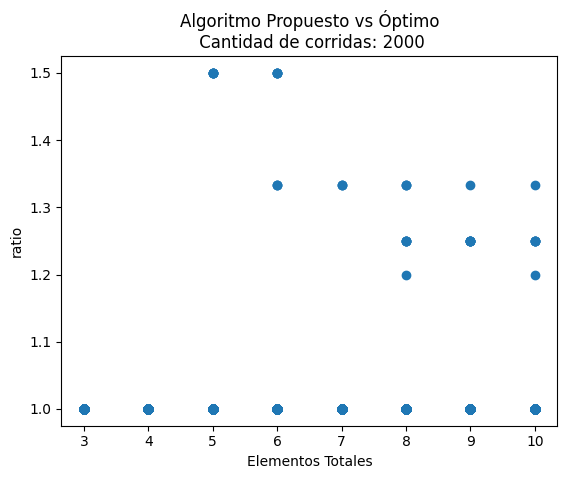

In [49]:
#df_graf_lower = df_lower.drop_duplicates(subset=['n','ratio'])
plt.scatter(df_smartpack_z['n'], df_smartpack_z['ratio'], alpha=1)
#plt.ylim(0, 1)
plt.xlabel("Elementos Totales")
plt.ylabel("ratio")
plt.title(f"Algoritmo Propuesto vs Óptimo\n Cantidad de corridas: {len(df_smartpack_z)}")
plt.show()

In [50]:
total_smartpack = len(df_smartpack_z)
grouping_z = {
    'r==1': (df_smartpack_z['ratio'] == 1).sum(),
    '1< r <= 1.5': ((df_smartpack_z['ratio'] > 1) & (df_smartpack_z['ratio']<= 1.5)).sum(),
    '1.5 < r <= 2': ((df_smartpack_z['ratio'] > 1.5) & (df_smartpack_z['ratio'] <=2 )).sum()
}
grouping_z

{'r==1': 1959, '1< r <= 1.5': 41, '1.5 < r <= 2': 0}

In [52]:
ratio_z_keys = []
ratio_z_counts = []
ratio_z_percs = []

for key, counts in grouping_z.items():
    ratio_z_keys.append(key)
    ratio_z_counts.append(counts)
    ratio_z_percs.append(counts/total_smartpack)

df_ratios_z = pd.DataFrame({'group': ratio_z_keys, 'count': ratio_z_counts, 'perc': ratio_z_percs})
print(df_ratios_z.to_latex(index=False, column_format='|c|c|c|'))
df_ratios_z

\begin{tabular}{|c|c|c|}
\toprule
group & count & perc \\
\midrule
r==1 & 1959 & 0.979500 \\
1< r <= 1.5 & 41 & 0.020500 \\
1.5 < r <= 2 & 0 & 0.000000 \\
\bottomrule
\end{tabular}



,group,count,perc
0,r==1,1959,0.9795
1,1< r <= 1.5,41,0.0205
2,1.5 < r <= 2,0,0.0000
